In [39]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert
import holidays


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [40]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//RevenuePessengerDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_penumpang': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# Drop the original date column
df.asfreq('d')
# df = df.drop('date', axis=1)
# df = df.drop('hijri', axis =1 )

df

,y,date,org,kode_org,des,kode_des
0,13755000,2022-12-09,TANJUNG PRIOK,431,NABIRE,982
1,10087000,2022-12-24,TANJUNG PRIOK,431,NABIRE,982
2,7336000,2023-01-07,TANJUNG PRIOK,431,NABIRE,982
3,15589000,2023-01-21,TANJUNG PRIOK,431,NABIRE,982
4,4585000,2023-02-04,TANJUNG PRIOK,431,NABIRE,982
...,...,...,...,...,...,...
85471,2980000,2023-05-11,AMBON,946,BAU-BAU,921
85472,3011000,2023-01-11,AMBON,946,BAU-BAU,921
85473,3011000,2023-03-31,AMBON,946,BAU-BAU,921
85474,3011000,2023-05-01,AMBON,946,BAU-BAU,921


In [41]:
df = df.groupby(['kode_des', 'date'], as_index=False)['y'].sum()
df

,kode_des,date,y
0,144,2022-12-03,27239000
1,144,2022-12-04,133154000
2,144,2022-12-10,120964000
3,144,2022-12-11,390796000
4,144,2022-12-16,95017000
...,...,...,...
5765,983,2023-05-16,17597000
5766,983,2023-05-19,758000
5767,983,2023-05-20,448000
5768,983,2023-05-22,1436000


In [42]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekofmonth'] = df['date'].apply(lambda x: (x.day-1) // 7 + 1) # calculate week of month
df['hijri_year'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().year)
df['hijri_month'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().month)
df['hijri_day'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().day)

df

,kode_des,date,y,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day
0,144,2022-12-03,27239000,2022,12,3,5,1,1444,5,9
1,144,2022-12-04,133154000,2022,12,4,6,1,1444,5,10
2,144,2022-12-10,120964000,2022,12,10,5,2,1444,5,16
3,144,2022-12-11,390796000,2022,12,11,6,2,1444,5,17
4,144,2022-12-16,95017000,2022,12,16,4,3,1444,5,22
...,...,...,...,...,...,...,...,...,...,...,...
5765,983,2023-05-16,17597000,2023,5,16,1,3,1444,10,26
5766,983,2023-05-19,758000,2023,5,19,4,3,1444,10,29
5767,983,2023-05-20,448000,2023,5,20,5,3,1444,10,30
5768,983,2023-05-22,1436000,2023,5,22,0,4,1444,11,2


In [43]:
id_holidays = holidays.ID(years=range(2020, 2024))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')
df_holidays

,day,event
0,2020-12-09,Hari Pemilihan
1,2020-01-01,Tahun Baru Masehi
2,2020-01-25,Tahun Baru Imlek
3,2020-03-25,Hari Suci Nyepi
4,2020-05-24,Hari Raya Idul Fitri
...,...,...
59,2023-05-01,Hari Buruh Internasional
60,2023-05-18,Kenaikan Yesus Kristus
61,2023-06-01,Hari Lahir Pancasila
62,2023-08-17,Hari Kemerdekaan Republik Indonesia


In [44]:
df['is_holiday']=df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)
df.loc[df['is_holiday']==1]

,kode_des,date,y,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day,is_holiday
20,144,2023-01-22,315339000,2023,1,22,6,4,1444,6,29,1
42,144,2023-04-07,221400000,2023,4,7,4,1,1444,9,16,1
51,144,2023-05-01,455164000,2023,5,1,0,1,1444,10,11,1
67,246,2023-01-01,3140000,2023,1,1,6,1,1444,6,8,1
71,246,2023-01-22,6526000,2023,1,22,6,4,1444,6,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5661,982,2023-05-18,396000,2023,5,18,3,3,1444,10,28,1
5685,983,2023-01-01,37198000,2023,1,1,6,1,1444,6,8,1
5701,983,2023-01-22,2470000,2023,1,22,6,4,1444,6,29,1
5740,983,2023-04-07,6460000,2023,4,7,4,1,1444,9,16,1


In [45]:
data = df.loc[df['kode_des'] == 431]
data = data.groupby(['year','month','day', 'weekday', 'weekofmonth','hijri_month', 'hijri_day', 'hijri_year','is_holiday'])['y'].sum()

data = pd.DataFrame(data)
data

y
year month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday           
2022 12    1   3       1           5           7         1444       0            20831000
           2   4       1           5           8         1444       0            56151000
           3   5       1           5           9         1444       0            45501000
           4   6       1           5           10        1444       0           173075000
           5   0       1           5           11        1444       0             6961000
...                                                                                   ...
2023 6     6   1       1           11          17        1444       0             1584000
           7   2       1           11          18        1444       0             2170000
           9   4       2           11          20        1444       0             4068000
           10  5       2           11          21        1444       0             2080000
           11  6       2           11          22        1444       0             4920000

[183 rows x 1 columns]

In [46]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using the IQR method
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data

y
year month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday           
2022 12    1   3       1           5           7         1444       0            20831000
           2   4       1           5           8         1444       0            56151000
           3   5       1           5           9         1444       0            45501000
           4   6       1           5           10        1444       0           173075000
           5   0       1           5           11        1444       0             6961000
...                                                                                   ...
2023 6     6   1       1           11          17        1444       0             1584000
           7   2       1           11          18        1444       0             2170000
           9   4       2           11          20        1444       0             4068000
           10  5       2           11          21        1444       0             2080000
           11  6       2           11          22        1444       0             4920000

[175 rows x 1 columns]

In [47]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [48]:
len(data)

175

In [49]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [50]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [51]:
scaled_train[:10]

array([[0.04420616],
       [0.12070224],
       [0.09763646],
       [0.37393632],
       [0.0141665 ],
       [0.39406311],
       [1.        ],
       [0.42816364],
       [0.23690611],
       [0.25407441]])

In [52]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [53]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [56]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
135/135 [==============================] - 3s 5ms/step - loss: 0.0693
Epoch 2/50
135/135 [==============================] - 1s 4ms/step - loss: 0.0595
Epoch 3/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0561
Epoch 4/50
135/135 [==============================] - 1s 4ms/step - loss: 0.0542
Epoch 5/50
135/135 [==============================] - 1s 4ms/step - loss: 0.0547
Epoch 6/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0527
Epoch 7/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0518
Epoch 8/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0510
Epoch 9/50
135/135 [==============================] - 1s 5ms/step - loss: 0.0513
Epoch 10/50
135/135 [==============================] - 1s 6ms/step - loss: 0.0519
Epoch 11/50
135/135 [==============================] - 1s 4ms/step - loss: 0.0506
Epoch 12/50
135/135 [==============================] - 1s 4ms/step - loss: 0.0488
Epoch 13/50
135/135 [====

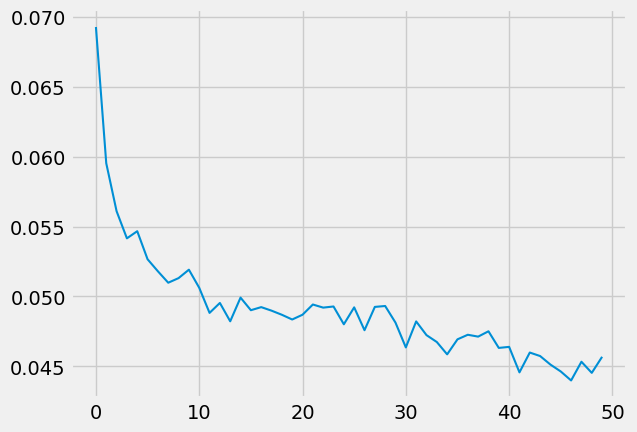

In [57]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [58]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 0s 184ms/step


array([[0.55757356]], dtype=float32)

In [59]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [60]:
test_predictions

[array([0.55757356], dtype=float32),
 array([0.43586785], dtype=float32),
 array([0.35187456], dtype=float32),
 array([0.30389923], dtype=float32),
 array([0.27425504], dtype=float32),
 array([0.30104452], dtype=float32),
 array([0.3314659], dtype=float32),
 array([0.37044203], dtype=float32),
 array([0.3578878], dtype=float32),
 array([0.39703962], dtype=float32),
 array([0.41291744], dtype=float32),
 array([0.43678218], dtype=float32),
 array([0.37711757], dtype=float32),
 array([0.3380309], dtype=float32),
 array([0.30501956], dtype=float32),
 array([0.28057742], dtype=float32),
 array([0.2649372], dtype=float32),
 array([0.25792214], dtype=float32),
 array([0.25709766], dtype=float32),
 array([0.26217544], dtype=float32),
 array([0.26603702], dtype=float32),
 array([0.273936], dtype=float32),
 array([0.27860218], dtype=float32),
 array([0.2825948], dtype=float32),
 array([0.27927223], dtype=float32),
 array([0.27481177], dtype=float32),
 array([0.26965097], dtype=float32),
 array([

In [61]:
test.head()

y
year month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday           
2023 5     9   1       2           10          19        1444       0            76067000
           10  2       2           10          20        1444       0            34596000
           11  3       2           10          21        1444       0            39549000
           12  4       2           10          22        1444       0           178082000
           13  5       2           10          23        1444       0           216496000

In [62]:
true_predictions = scaler.inverse_transform(test_predictions)

In [63]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_21976\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


y   
year month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday              
2023 5     9   1       2           10          19        1444       0            76067000  \
           10  2       2           10          20        1444       0            34596000   
           11  3       2           10          21        1444       0            39549000   
           12  4       2           10          22        1444       0           178082000   
           13  5       2           10          23        1444       0           216496000   

                                                                                 Predictions  
year month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday                
2023 5     9   1       2           10          19        1444       0           2.578645e+08  
           10  2       2           10          20        1444       0           2.016702e+08  
           11  3       2           10          21        1444       0           1.628886e+08  
           12  4       2           10          22        1444       0           1.407373e+08  
           13  5       2           10          23        1444       0           1.270499e+08

<Axes: xlabel='year,month,day,weekday,weekofmonth,hijri_month,hijri_day,hijri_year,is_holiday'>

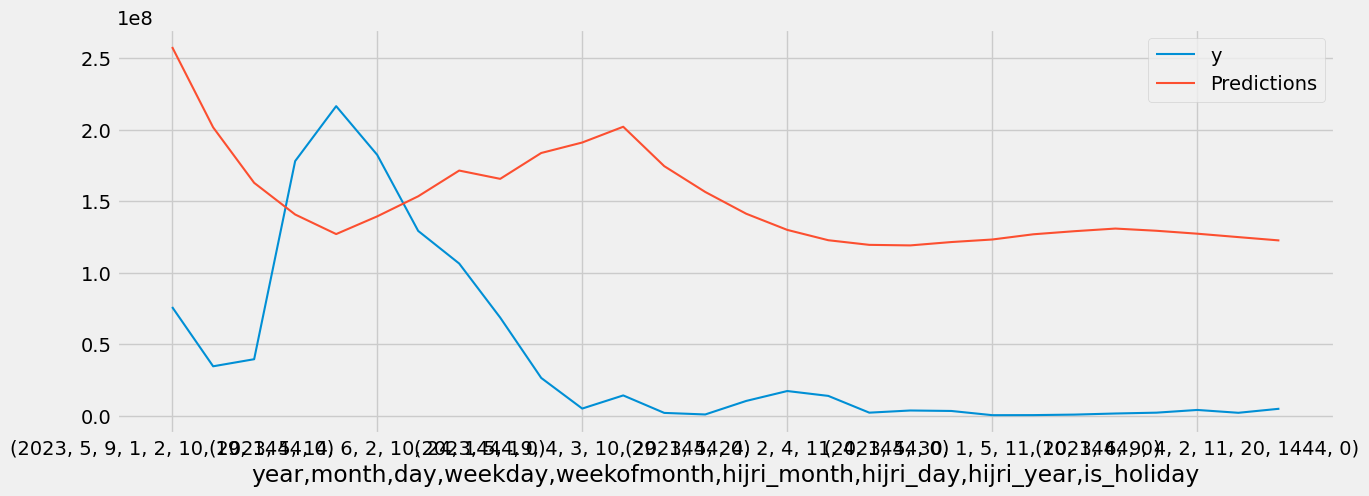

In [64]:
test.plot(figsize=(14,5))

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 127829274.78102973
Mean Value of Test Dataset: 40984500.0
